# Beyond Image Classification

Deep learning is more than deciding if an image is a cat or dog (that's only 90% of the field). There is a wide variety of problems that we often encounter in computer vision.

In this lab I'll review a few common ones and some constraints of each, as well as some "starter" architectures that might be good for a *project*. 

**Sidenote:** I know that some of you are starting your projects soon, please ask me questions if you have any (especially on the implementation side). Now is a good reminder as well that part of your grade will come from how well you can answer my questions about your project (during the final presentation), so make sure to understand what you're doing!


## Object Detection
Object detection is the most similar to classic image classification, some methods even use classification models internally. 

We define object detection as "detecting one or more objects within a single image". We can break this problem roughly into a "what + where" problem. See example:

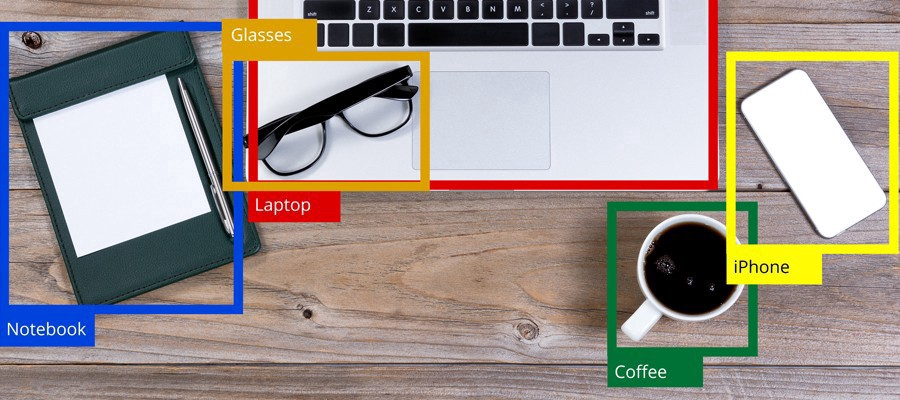


So thats what it is, how do we do it? There are a variety of competing approaches, so this is by no means an exaustive list.

(adapted partially from: https://www.fritz.ai/object-detection/)

### R-CNNs
R-CNN stands for "region" CNN. They by using a common backbone (generic set of conv layers) to create an image-wide feature map. An additional network then uses the feature map to construct "region proposals" (regions of a consistent class). Finally the features are pooled within the region to create a classification score per-region.

**Faster R-CNN Architecture:**
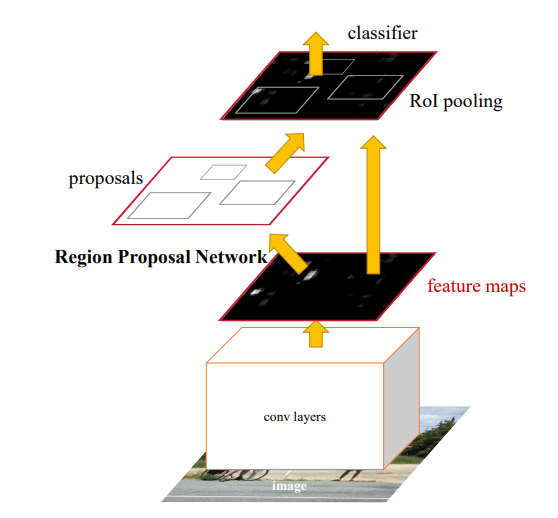

## Single-Shot Detectors

Single-Shot Detectors (or SSDs) primarly differ in that they use a fixed set of "anchor points" to define the boundaries of regions in the image. This makes them faster, but have a little less flexibility to define exactly the location of an object.

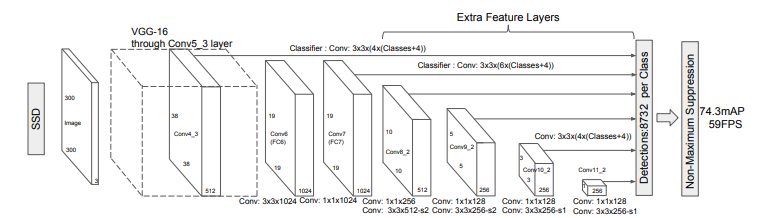

## What should I use?
If you're just starting out a project and want to use an object detector here are some generic architecture recommendations:

For best performance:
- EfficientDet is currently amoung the SOTA models, here are a few implementations
    - https://github.com/google/automl/tree/master/efficientdet
    - https://github.com/xuannianz/EfficientDet
    - https://github.com/qubvel/efficientnet
- YOLO-V4, runs very fast, no great Tensorflow Implementations yet (there are some but not reliable)
    - https://blog.roboflow.com/a-new-video-tutorial-yolov4-in-pytorch/
    - https://github.com/Tianxiaomo/pytorch-YOLOv4

For simplicity, understandability you can look at the tensorflow implementations
- https://github.com/tensorflow/models/tree/master/official#object-detection-and-segmentation


# Image Segmentation

Another common image processing task is image segmentation. I like to think of image segmentation as a pixel-labelling task. The key attribute of image segmentation is that the output size is approximately the same size as the input size (minus some edge effects). 

When talking about "image segmentation" we also tend to include "image regression" tasks. Where instead of a discrete label for each pixel we are predicting a continous value. For example predicting a fluorescent image from an unstained trasmitted light image

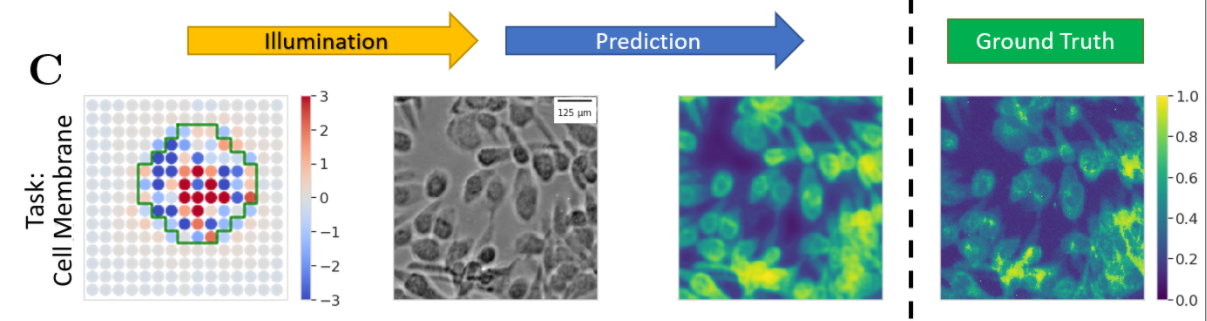

There are two key features you find in most image segmentation models.

1. They are (mostly) fully convolutional. This means that all of our parameterizable layers are convolutions, mostly this means no fully connected or recurrent layers
2. Good ones preserve multiple levels of spatial scale. Since we are predicting images from images its useful to keep a "high resolution" version of the image instead of continously down-sampling.

## Some architectures

### SegNet (for historical reference only)
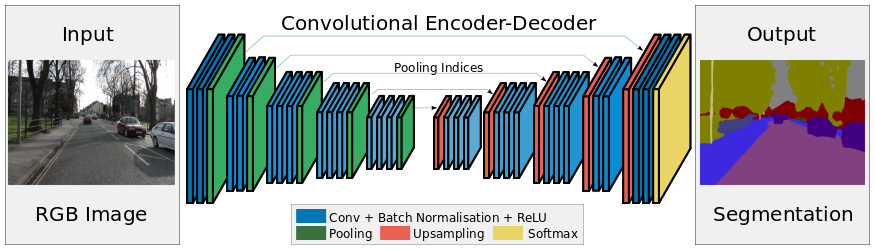

### U-Net

This is the architecture I used for my paper
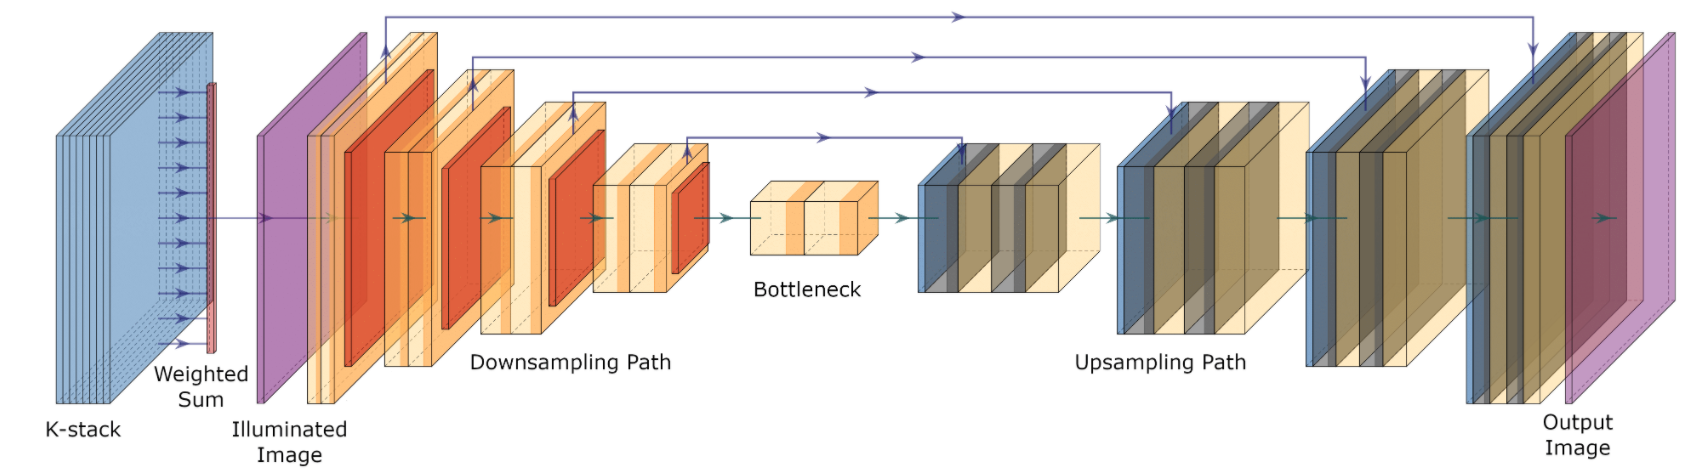

### HR-Net
This is my preferred architecture now
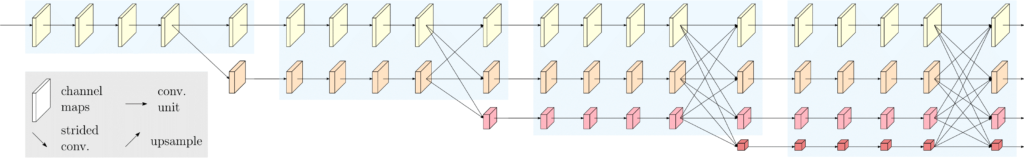


## What should I use?

I would recommend most people _start_ with a U-Net model as it's simple and fast. If you want higher performance move to HR-Net.

**U-Net**:
- https://github.com/zhixuhao/unet/blob/master/model.py
- You don't even need a reference if you want to code it yourself

**HR-Net:**
- (PyTorch): https://github.com/HRNet/HRNet-Semantic-Segmentation/tree/pytorch-v1.1
- There aren't any high quality implementations, but a few unvetted ones:
    - https://github.com/niecongchong/HRNet-keras-semantic-segmentation
    - https://github.com/yuanyuanli85/tf-hrnet
    

# Exercises

For the rest of this lab we will start on a semantic segmentation task using *SegNet*. A few caveats
1. We are reaching the point when training a model takes longer than we realistically have in the lab session
2. As I mention above this architecture is not advisable for use in performance-sensitive applications

## Exercise 1A - Data Wrangling

Unfortunately much of deep learning isn't actually building models and training networks. It is understanding and reprsenting your data.


In this exercise I would like you to load the data from disk (it's already unzipped and downloaded with the provided code) then training/test sets from the images (don't worry about validation). I've provided some template code to get you started.


In [1]:
# loading and unzipping, should take 30s to a minute
!wget https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip
!unzip stage1_train.zip > /dev/null

--2020-10-19 19:04:32--  https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82923446 (79M) [application/zip]
Saving to: ‘stage1_train.zip’

stage1_train.zip    100%[===================>]  79.08M  3.88MB/s    in 21s     

2020-10-19 19:04:52 (3.83 MB/s) - ‘stage1_train.zip’ saved [82923446/82923446]



Some useful code snippets

**Reading an image to a numpy array using OpenCV**

Note the `0` is to read the image as single-channel, or grayscale
```
image_path = 'path/to/image.jpg'
image = cv.imread(image_path, 0)
```

**Working with files**
```
list_of_files = glob.glob('folder_name/*.jpg')
list_of_subfolders = glob.glob('*/folder_name/*.jpg')
```

**Stacking a list of images:**
```
image_stack = np.stack(images, axis=0)
```

**Union of Images:**

You don't need to understand this code
```
from functools import reduce
union_image = reduce(np.bitwise_or, list_of_images)
```

**File Structure of Dataset:**

- The files are stored each in their own folder, the folder names are hashes (so they look like random sequences of letters and numbers). For example:
`d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0` is a folder name. 
- Inside each folder is a `images` and `masks` folder
- Inside the image folder is a single `png` image which is our **input** image
- Inside the mask folder is a set of `png` images which are the masks of each nucleus
    - There are multiple masks per input image, as each one represents a single nucleus
    - You'll need to merge the masks together (union of the masks)

You can get a list of all the folders like this:
```
all_folders = [os.path.dirname(p) for p in glob.glob('*/images')]
```

Example file tree:
```
d1dbc6ee7...aff0/
                images/
                    d1dbc6ee7c44a7027e935d040e496793186b884a1028d0e26284a206c6f5aff0.png
                masks/
                    0563bd8bd66cc99f9b1813387342e4813ebb5f7da15c4b7401dafacb91829a71.png
                    112dcf3c819abadc2be3728aa5c04f20a81b62268de824b82e1013e30425673f.png
                    258718e5d875247af7d9102c01c82d820933b5600bfa4d1318c68a03cf547f8f.png
                    39ab1918585aec808c4e253894ca34a32e8f1f6ddc32cc9177b7f9d1bbdd679d.png
                    46f843a73f3e353d87b275f71808b7d97c03147e4bd4f849f658d9b6b207d695.png
                    4c1816abc7d75f84cfbe185ca6745a86d701f301ada1ae1e584b2bade62dc540.png
                    67512af03f2333640009da600812f200a582125696a7b7da1f8f3e08a949638c.png
                    6e5de12a44caa77b7ad271d5e7401266bfc84f90332ca45ad83edc3206ab2d7a.png
                    7b09dcc7ca61bcfe0c5b58f40ef44d35e467d39df53d10df62d1b6a558623128.png
                    928a8c06767ad3e68b60b46782c9edcfa788986a487e9fcb8b3a3d31d5d988ae.png
                    a3b11f748a6d90eae945720f3947257d998627a1bae735f005615dee3d1dd471.png
                    a463d5ff97237f8c5e1a8a84035a36f8e6cf50a73231efc43e28d2bf00515735.png
                    a9354077b4e97fc078068492ed4c60b4ff422eec123b2c440d6cdba1caff39a6.png
                    ca2575e30ded3d8b6231b8a6cf0eaac6f480bdad1205aacbc5504b3694a2fb32.png
                    cc91341746368e876a63890c1ca520d0e7a88b31fd0551eadc1a697484c42002.png
                    e58c2ecf3fe45c3f3d13df30a05f6e4d65f59c1d62a0dc9cacfb224485635c87.png
                    efc87834524ac03482508c9e8b83de26d86bde6fc1b7925322767c2e2e2f37ff.png
```



In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
from functools import reduce
from tqdm import tqdm

def read_image(image_path):
    image = cv.imread(image_path, 0)
    resized = cv.resize(image, (256, 256))
    return resized

In [3]:
all_folders = [os.path.dirname(p) for p in glob.glob('*/images')]
# hint: if you want a progress bar you can use tqdm:
# for folder in tqdm(all_folders):
#     pass

# Exercise 1B - Visualizing Images

Once you have your images loaded into arrays we want to visualize them to make sure that the training data is correct.

For segmentation tasks a nice way of doing this is to overlay the target mask on top of the input image.

- Overlay three examples of input images and masks

Overlaying two images
```
fig, axs = plt.subplots(nrows=1, ncols=1)
axs.imshow(image_1, cmap=plt.cm.gray)
axs.imshow(image_2, alpha=0.5)
```

# Exercise 2A - Create a segmentation model

I've written a function which will generate a model for you. Create an instance of this model, compile it, then print the summary. 

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Input, UpSampling2D
import tensorflow as tf

def create_segnet(input_shape, num_classes):
    input_layer = Input(input_shape)
    x = input_layer
    # down path
    start_filters = 8
    for i in range(3):
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters * (2**i), 3, padding='same', activation='relu')(x)
        x = MaxPool2D()(x)
    # bottleneck
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    x = Conv2D(start_filters*(2**3),3, padding='same', activation='relu')(x)
    # up path
    for i in range(3):
        x = UpSampling2D()(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
        x = Conv2D(start_filters*(2**(2-i)),3, padding='same', activation='relu')(x)
    output = Conv2D(num_classes, 1, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    return model

# Exercise 2B - Visualizing and Training your model



1.   Predict one of your test images **before** training your model
    - Overlay this prediction on top of the input image as you did before
2.   Train your model on your training data (5 epochs)
3.   Predict the same test image and overlay it again, what is the difference?


# Exercise 3A - Improving your model

As we discussed in the opener the `SegNet` architecture I used isn't very performant because there is no pathway for high resolution images. In this exercise you will modify the segnet model I created to add a single skip connection and concatenation.

**Specifically**:
- Create a skip connection between the fourth convolutional layer and the 11th convolutional layer
    - This is the convolution layer in the second block of the down path and the first convolution of the second block in the up path

Helpful code snippets

**Creating a skip connection between two layers**:
```
# grab the start of the skip connection
skip_start = x
...
...
# when you want to re-connect
x = tf.concat([skip_start, x], axis=-1)
```

In [11]:
def create_skipnet(input_shape, num_classes):
    ...

# Exercise 3B: Train your new model

- Compare the results from the skip-connection model to the old model, are they better, worse, or the same?
- Add a second skip connection, does the trend continue?


# Bonus Exercise: Create a U-Net

- As you can see if we keep adding skip connections we get to the standard U-Net architecture
- Replicate the U-Net architecture by adding skip connections between every convolutional block (down --> up)
